In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sea
from sklearn.neighbors import KNeighborsClassifier
import catboost as cat
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split


def quality_metrics(marks, preds):
    """
    Функция выводит значения основных показателей качества обучения модели
    """
    print("Accuracy: {0:.9f}".format(accuracy_score(marks, preds)))
    print("Precision: {0:.9f}".format(precision_score(marks, preds, average='macro')))
    print("Recall: {0:.9f}".format(recall_score(marks, preds, average='macro')))
    print("F1: {0:.9f}".format(f1_score(marks, preds, average='macro')))

def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features


In [2]:
dataset = pd.read_csv('selection_main.csv', delimiter=',')

In [3]:
dataset = dataset.sample(frac=1)

In [4]:
dataset

,Unnamed: 0,url,title,tags_names,abstract,class
8563,8563,https://arxiv.org/abs/2205.04229,Near-collisions and their Impact on Biometric ...,Cryptography and Security,Biometric recognition encompasses two operatin...,Database
6472,6472,https://arxiv.org/abs/2202.03126,Reasoning for Complex Data through Ensemble-ba...,Computer Vision and Pattern Recognition,Self-supervised learning deals with problems t...,Text Mining
7341,7341,https://arxiv.org/abs/2209.07040,Learning-Based Adaptive Control for Stochastic...,Systems and Control; Machine Learning; Optimiz...,We propose a certainty-equivalence scheme for ...,Control Systems
510,510,https://arxiv.org/abs/2204.09718,Matching Writers to Content Writing Tasks,Computation and Language; Artificial Intellige...,Businesses need content. In various forms and ...,Expert
1276,1276,https://arxiv.org/abs/2204.10590,Emergent Communication for Understanding Human...,Computation and Language; Machine Learning; Ne...,Emergent communication protocols among humans ...,Neural Nets
...,...,...,...,...,...,...
5591,5591,https://arxiv.org/abs/2203.04752,Using Human Gaze For Surgical Activity Recogni...,Image and Video Processing; Computer Vision an...,Automatically recognizing surgical activities ...,Computer Vision
7560,7560,https://arxiv.org/abs/2209.01542,Recurrent Bilinear Optimization for Binary Neu...,Computer Vision and Pattern Recognition,Binary Neural Networks (BNNs) show great promi...,Control Systems
3336,3336,https://arxiv.org/abs/2009.10515,A Fuzzy Logic Controller for Tasks Scheduling ...,"Distributed, Parallel, and Cluster Computing",The Cloud infrastructure offers to end users a...,Fuzzy
1662,1662,https://arxiv.org/abs/2112.06532,A Complete Characterisation of ReLU-Invariant ...,Machine Learning; Probability; Statistics Theory,We give a complete characterisation of familie...,Neural Nets


Датасет представляет собой набор из 10000 строк, в которых содержится информация о научных статьях из мира IT. В датасете присутвуют ссылка на статью, заголовк, тэги, краткое содержание и метка класса.

In [5]:
training, test = dataset.iloc[:7000], dataset.iloc[7000:]

In [6]:
training['class'].value_counts()

Fuzzy                                         723
Expert                                        713
Control Systems                               712
Robotic                                       707
Information Retrieval, Recommender Systems    704
Cyber Security                                704
Neural Nets                                   695
Text Mining                                   693
Computer Vision                               690
Database                                      659
Name: class, dtype: int64

In [7]:
test['class'].value_counts()

Database                                      341
Computer Vision                               310
Text Mining                                   307
Neural Nets                                   305
Information Retrieval, Recommender Systems    296
Cyber Security                                296
Robotic                                       293
Control Systems                               288
Expert                                        287
Fuzzy                                         277
Name: class, dtype: int64

In [8]:
stopwords = stopwords.words('english')

In [9]:
tokenizer = WordPunctTokenizer()
training['title'] = [tokenizer.tokenize(x.lower()) for x in training['title']]
training['abstract'] = [tokenizer.tokenize(x.lower()) for x in training['abstract']]
training['tags_names'] = [tokenizer.tokenize(x.lower()) for x in training['tags_names']]
test['title'] = [tokenizer.tokenize(x.lower()) for x in test['title']]
test['abstract'] = [tokenizer.tokenize(x.lower()) for x in test['abstract']]
test['tags_names'] = [tokenizer.tokenize(x.lower()) for x in test['tags_names']]

C:\Users\777\AppData\Local\Temp\ipykernel_10648\3745973656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['title'] = [tokenizer.tokenize(x.lower()) for x in training['title']]
C:\Users\777\AppData\Local\Temp\ipykernel_10648\3745973656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['abstract'] = [tokenizer.tokenize(x.lower()) for x in training['abstract']]
C:\Users\777\AppData\Local\Temp\ipykernel_10648\3745973656.py:4: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [10]:
for i in ['title', 'abstract', 'tags_names']:
    training[i] = [[x for x in y if x not in stopwords] for y in training[i]]
    test[i] = [[x for x in y if x not in stopwords] for y in test[i]]


C:\Users\777\AppData\Local\Temp\ipykernel_10648\779023132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training[i] = [[x for x in y if x not in stopwords] for y in training[i]]
C:\Users\777\AppData\Local\Temp\ipykernel_10648\779023132.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i] = [[x for x in y if x not in stopwords] for y in test[i]]


In [11]:
for i in ['title', 'abstract', 'tags_names']:
    assert all(isinstance(row, (list, tuple)) for row in training[i]), "please convert each line into a list of tokens (strings)"
    assert all(all(isinstance(tok, str) for tok in row) for row in training[i]), "please convert each line into a list of tokens (strings)"
    is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
    assert all(map(lambda l: not is_latin(l) or l.islower(), map(' '.join, training[i]))), "please make sure to lowercase the data"

In [12]:
for i in ['title', 'abstract', 'tags_names']:
    assert all(isinstance(row, (list, tuple)) for row in test[i]), "please convert each line into a list of tokens (strings)"
    assert all(all(isinstance(tok, str) for tok in row) for row in test[i]), "please convert each line into a list of tokens (strings)"
    is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
    assert all(map(lambda l: not is_latin(l) or l.islower(), map(' '.join, test[i]))), "please make sure to lowercase the data"

In [13]:
training = training.drop(columns=['url', 'Unnamed: 0'])
test = test.drop(columns=['url', 'Unnamed: 0'])

In [14]:
training['text'] = training['title'] + training['tags_names'] + training['abstract']
test['text'] = test['title'] + test['tags_names'] + test['abstract']

In [15]:
training = training.drop(columns=['title', 'tags_names', 'abstract'])
test = test.drop(columns=['title', 'tags_names', 'abstract'])

In [16]:
training = training[['text', 'class']]
test = test[['text', 'class']]

In [17]:
lem = WordNetLemmatizer()
training['text'] = [[lem.lemmatize(x) for x in i] for i in training['text']]
training['text'] = [[x for x in i if x.isalpha()] for i in training['text']]

In [18]:
clses = ['Computer Vision', 'Control Systems', 'Cyber Security', 'Database', 'Expert', 'Fuzzy', "Information Retrieval, Recommender Systems", 'Neural Nets', 'Robotic', 'Text Mining']
dic_lbls = {clses[i]:i  for i in range(10)}
training = training.replace(dic_lbls)
training['labels'] = training['class']
training = training.drop(columns=['class'])
dic_lbls

{'Computer Vision': 0,
 'Control Systems': 1,
 'Cyber Security': 2,
 'Database': 3,
 'Expert': 4,
 'Fuzzy': 5,
 'Information Retrieval, Recommender Systems': 6,
 'Neural Nets': 7,
 'Robotic': 8,
 'Text Mining': 9}

In [19]:
training

,text,labels
8563,"[near, collision, impact, biometric, security,...",3
6472,"[reasoning, complex, data, ensemble, based, se...",9
7341,"[learning, based, adaptive, control, stochasti...",1
510,"[matching, writer, content, writing, task, com...",4
1276,"[emergent, communication, understanding, human...",7
...,...,...
8769,"[semantic, pose, verification, outdoor, visual...",3
5873,"[short, range, correlation, transformer, occlu...",0
8605,"[private, sequential, hypothesis, testing, sta...",3
8190,"[wrangler, emergency, event, database, tool, g...",3


In [20]:
test['text'] = [[lem.lemmatize(x) for x in i] for i in test['text']]
test['text'] = [[x for x in i if x.isalpha()] for i in test['text']]
test = test.replace(dic_lbls)
test['labels'] = test['class']
test = test.drop(columns=['class'])

In [21]:
test

,text,labels
479,"[hierarchical, control, cooperative, team, com...",4
1595,"[neural, architecture, search, inversion, mach...",7
4230,"[multi, stage, clarification, conversational, ...",6
1060,"[automatic, differentiation, optimization, dif...",7
3544,"[deep, fuzzy, system, computer, science, artif...",5
...,...,...
5591,"[using, human, gaze, surgical, activity, recog...",0
7560,"[recurrent, bilinear, optimization, binary, ne...",1
3336,"[fuzzy, logic, controller, task, scheduling, u...",5
1662,"[complete, characterisation, relu, invariant, ...",7


In [22]:

training

,text,labels
8563,"[near, collision, impact, biometric, security,...",3
6472,"[reasoning, complex, data, ensemble, based, se...",9
7341,"[learning, based, adaptive, control, stochasti...",1
510,"[matching, writer, content, writing, task, com...",4
1276,"[emergent, communication, understanding, human...",7
...,...,...
8769,"[semantic, pose, verification, outdoor, visual...",3
5873,"[short, range, correlation, transformer, occlu...",0
8605,"[private, sequential, hypothesis, testing, sta...",3
8190,"[wrangler, emergency, event, database, tool, g...",3


In [23]:
df = pd.concat([training, test])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['labels'], test_size=0.3, stratify=df['labels'], random_state=123
)

In [25]:
corpus = X_train.values

In [26]:
w2v_model = Word2Vec(
    min_count=10,
    window=2,
    vector_size=300,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=0,
    workers=15)

In [27]:
w2v_model.build_vocab(corpus)

In [30]:
corpus.shape

(7000,)

In [29]:
w2v_model.corpus_count

7000

In [31]:
w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
w2v_model.init_sims(replace=True)

C:\Users\777\AppData\Local\Temp\ipykernel_10648\2644820405.py:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [32]:
w2v_model.wv.most_similar('convolutional')

[('neural', 0.6095843315124512),
 ('network', 0.6001325249671936),
 ('deep', 0.5431220531463623),
 ('cnn', 0.5288028717041016),
 ('convolution', 0.49997010827064514),
 ('transformer', 0.49152040481567383),
 ('cnns', 0.4910784065723419),
 ('net', 0.46939462423324585),
 ('architecture', 0.43603968620300293),
 ('recurrent', 0.40066906809806824)]

In [33]:
w2v_model.wv.vectors_lockf = np.ones(len(w2v_model.wv))

In [31]:
w2v_model.wv.intersect_word2vec_format("D:\zagruzki_musor\GoogleNews-vectors-negative300.bin", binary=True)


In [32]:
w2v_model.wv.most_similar('convolutional')

[('metamaterials', 0.7017061114311218),
 ('biomolecules', 0.6935909986495972),
 ('nucleus', 0.5903359055519104),
 ('cfd', 0.5872335433959961),
 ('solar', 0.5831857919692993),
 ('metastasis', 0.5514416694641113),
 ('printing', 0.5400155782699585),
 ('decomposition', 0.5356024503707886),
 ('pruned', 0.5176980495452881),
 ('yield', 0.5115835666656494)]

In [34]:
vectorized_docs_train = vectorize(X_train.values, model = w2v_model)
vectorized_docs_test = vectorize(X_test.values, model = w2v_model)

In [39]:
len(vectorized_docs_train[3])

300

# Дообучено на Google

In [34]:
grid={"C":np.logspace(-3,3,20), "penalty":['l1', 'l2', 'elasticnet'], "solver":['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 'max_iter':[100,200,300],'verbose':[1]}
scoring = ['f1']
logreg=LogisticRegression(n_jobs=-1)
random_search = RandomizedSearchCV(estimator=logreg,
                           param_distributions=grid,
                           n_iter=100,
                           scoring=scoring,
                           refit='f1',
                           cv=3,
                           verbose=8000)

random_result = random_search.fit(vectorized_docs_train, y_train)
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_f1'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

KeyboardInterrupt: 

 {'verbose': 1, 'solver': 'sag', 'penalty': 'l2', 'max_iter': 100, 'C': 0.3359818286283781}

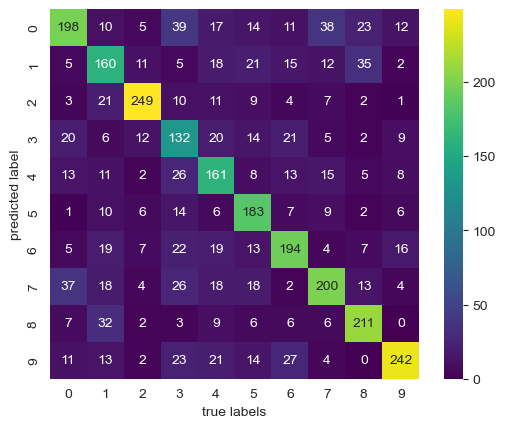

Accuracy: 0.643333333
Precision: 0.644892076
Recall: 0.643333333
F1: 0.640954453


In [34]:
clf = LogisticRegression( random_state=64, solver='lbfgs', max_iter=10000, n_jobs=-1)
clf.fit(vectorized_docs_train, y_train)

w2vec_pred_LR = clf.predict(vectorized_docs_test)

mat = confusion_matrix(y_test, w2vec_pred_LR)
sea.heatmap(mat.T, square = True, annot=True, fmt = "d", cmap='viridis')
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
quality_metrics(y_test, w2vec_pred_LR)

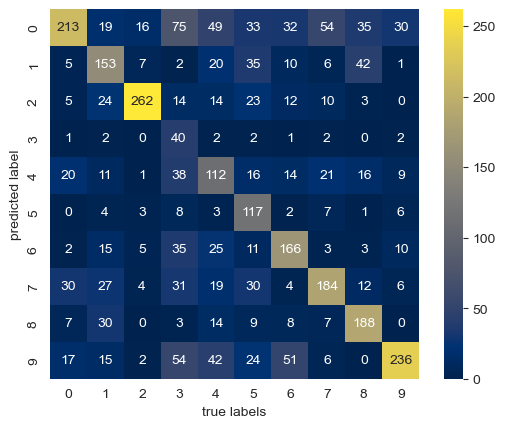

Accuracy: 0.557000000
Precision: 0.598827455
Recall: 0.557000000
F1: 0.539984433


In [35]:
clf = KNeighborsClassifier(n_neighbors=120)
clf.fit(vectorized_docs_train, y_train)

w2vec_pred_KNeighbors = clf.predict(vectorized_docs_test)

mat = confusion_matrix(y_test, w2vec_pred_KNeighbors)
sea.heatmap(mat.T, square = True, annot=True, fmt = "d", cmap='cividis')
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
quality_metrics(y_test, w2vec_pred_KNeighbors)

In [32]:
param_grid = {"iterations":[300, 400, 500],
              #'eval_metric': ['Recall', 'Logloss', 'F1', 'TotalF1', 'Kappa', 'WKappa'],
              'grow_policy': [ 'Depthwise' , 'Lossguide'],
              'bootstrap_type': ['Poisson','Bernoulli'],
              'sampling_frequency': ['PerTree'],
              'min_data_in_leaf': [1, 2, 3],
              'subsample': [0.3, 0.5, 0.7],
              'leaf_estimation_method': ['Gradient'],
              "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
              "depth": range(3, 21, 3),
              'random_strength': [0.7, 0.6, 0.8, 0.1],
              'boosting_type': ['Plain'],
              "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}

In [ ]:
ct= cat.CatBoostClassifier(task_type="GPU",loss_function='MultiClass',eval_metric='MultiClass')

random_search = ct.randomized_search(param_distributions=param_grid,
                                     X=vectorized_docs_train,
                                     y=training['labels'],
                                     cv=3,
                                     n_iter=10,
                                     verbose=1,
                                     plot=True)

print("best params:\n", ct.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2395167	test: 2.2514230	best: 2.2514230 (0)	total: 16.1ms	remaining: 6.43s
300:	learn: 0.2690398	test: 1.2016978	best: 1.2016978 (300)	total: 3.73s	remaining: 1.23s
399:	learn: 0.1808913	test: 1.1827222	best: 1.1827222 (399)	total: 4.82s	remaining: 0us
bestTest = 1.182722249
bestIteration = 399


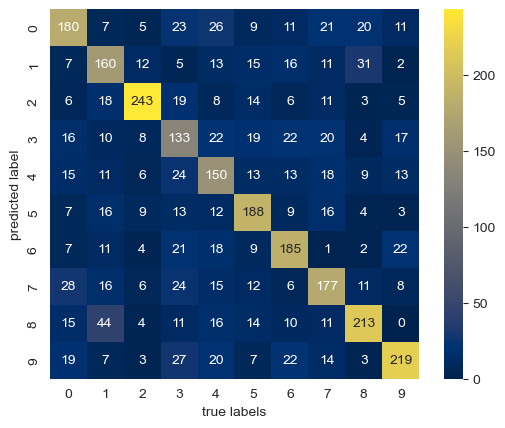

Accuracy: 0.616000000
Precision: 0.616000000
Recall: 0.616000000
F1: 0.616000000


In [80]:
params = {'loss_function': 'MultiClass',
          'eval_metric': 'TotalF1', #Recall, Logloss, F1, TotalF1, Kappa, WKappa
          'task_type': 'GPU',
          'min_data_in_leaf': 0.1,
          'depth': 12,
          'iterations': 1000,
          'subsample': 0.5,
          'random_strength': 0.6,
          'learning_rate': 0.005,
          'l2_leaf_reg': 1e-05,
          'grow_policy': 'Depthwise',
          'boosting_type': 'Plain',
          'sampling_frequency': 'PerTree',
          'auto_class_weights': 'SqrtBalanced',
          'leaf_estimation_method': 'Gradient',
          'bootstrap_type': 'Bernoulli'}

params = {'loss_function': 'MultiClass', 'eval_metric': 'MultiClass', 'task_type': 'GPU', 'min_data_in_leaf': 2, 'depth': 12, 'l2_leaf_reg': 10, 'iterations': 400, 'subsample': 0.3, 'random_strength': 0.7, 'learning_rate': 0.1, 'grow_policy': 'Lossguide', 'boosting_type': 'Plain', 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Gradient', 'bootstrap_type': 'Bernoulli'}
model_n = cat.CatBoostClassifier(**params,verbose=True)
#train model
model_n.fit(vectorized_docs_train, y_train, eval_set=(vectorized_docs_test, y_test),

                              verbose_eval=300,
                              early_stopping_rounds=500,
                              use_best_model=True,
                              plot=True)
y_cb = model_n.predict(vectorized_docs_test)
mat = confusion_matrix(y_test, y_cb)
sea.heatmap(mat.T, square = True, annot=True, fmt = "d", cmap='cividis')
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
quality_metrics(y_test, y_cb)

# Обучено на своих Данных

In [26]:
w2v_model = Word2Vec(
    min_count=10,
    window=2,
    vector_size=300,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=0,
    workers=15)
w2v_model.build_vocab(corpus)
w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
w2v_model.init_sims(replace=True)

C:\Users\777\AppData\Local\Temp\ipykernel_9368\403345055.py:13: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [27]:
vectorized_docs_train = vectorize(X_train.values, model = w2v_model)
vectorized_docs_test = vectorize(X_test.values, model = w2v_model)

In [ ]:
grid={"C":np.logspace(-3,3,20), "penalty":['l1', 'l2', 'elasticnet'], "solver":['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 'max_iter':[100,200,300],'verbose':[1]}
scoring = ['f1']
logreg=LogisticRegression(n_jobs=-1)
random_search = RandomizedSearchCV(estimator=logreg,
                           param_distributions=grid,
                           n_iter=50,
                           scoring=scoring,
                           refit='f1',
                           cv=3,
                           verbose=8000)

random_result = random_search.fit(vectorized_docs_train, training['labels'])

In [ ]:
random_result
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_f1'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

 {'verbose': 1, 'solver': 'sag', 'penalty': 'l2', 'max_iter': 100, 'C': 0.3359818286283781}
solver='lbfgs', max_iter=10000,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.3s finished


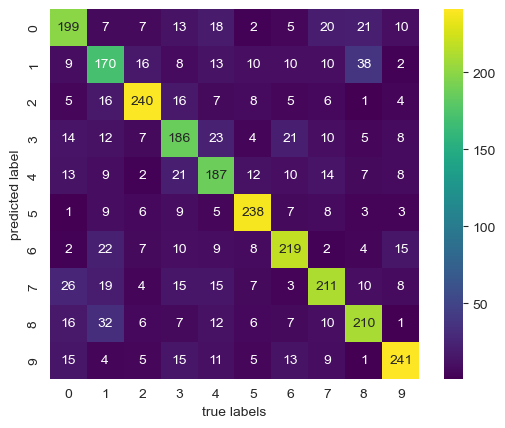

Accuracy: 0.700333333
Precision: 0.700333333
Recall: 0.700333333
F1: 0.700333333


In [83]:
clf = LogisticRegression( random_state=64, verbose=1, solver='lbfgs', penalty='l2', max_iter= 1000, C=233.9359818286283781, n_jobs=-1)
clf.fit(vectorized_docs_train, y_train)

w2vec_pred_LR = clf.predict(vectorized_docs_test)

mat = confusion_matrix(y_test, w2vec_pred_LR)
sea.heatmap(mat.T, square = True, annot=True, fmt = "d", cmap='viridis')
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
quality_metrics(y_test, w2vec_pred_LR)

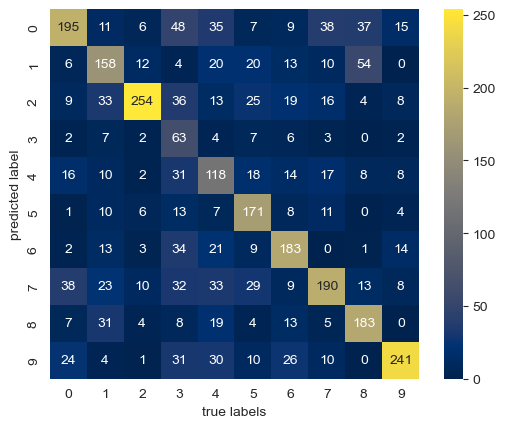

Accuracy: 0.585333333
Precision: 0.585333333
Recall: 0.585333333
F1: 0.585333333


In [84]:
clf = KNeighborsClassifier(n_neighbors=100)
clf.fit(vectorized_docs_train, y_train)

w2vec_pred_KNeighbors = clf.predict(vectorized_docs_test)

mat = confusion_matrix(y_test, w2vec_pred_KNeighbors)
sea.heatmap(mat.T, square = True, annot=True, fmt = "d", cmap='cividis')
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
quality_metrics(y_test, w2vec_pred_KNeighbors)

In [ ]:
param_grid = {"iterations": [300, 400, 500],
              #'eval_metric': ['Recall', 'Logloss', 'F1', 'TotalF1', 'Kappa', 'WKappa'],
              'grow_policy': ['Depthwise', 'Lossguide'],
              'bootstrap_type': ['Poisson', 'Bernoulli'],
              'sampling_frequency': ['PerTree'],
              'min_data_in_leaf': [1, 2, 3],
              'subsample': [0.3, 0.5, 0.7],
              'leaf_estimation_method': ['Gradient'],
              "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
              "depth": range(3, 21, 3),
              'random_strength': [0.7, 0.6, 0.8, 0.1],
              'boosting_type': ['Plain'],
              "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}
ct = cat.CatBoostClassifier(task_type="GPU", loss_function='MultiClass', eval_metric='MultiClass')

random_search = ct.randomized_search(param_distributions=param_grid,
                                     X=vectorized_docs_train,
                                     y=training['labels'],
                                     cv=3,
                                     n_iter=20,
                                     verbose=1,
                                     plot=True)

print("best params:\n", ct.get_params())

In [28]:
params = {'loss_function': 'MultiClass',
          'eval_metric': 'TotalF1', #Recall, Logloss, F1, TotalF1, Kappa, WKappa
          'task_type': 'GPU',
          'min_data_in_leaf': 0.1,
          'depth': 12,
          'iterations': 1000,
          'subsample': 0.5,
          'random_strength': 0.6,
          'learning_rate': 0.005,
          'l2_leaf_reg': 1e-05,
          'grow_policy': 'Depthwise',
          'boosting_type': 'Plain',
          'sampling_frequency': 'PerTree',
          'auto_class_weights': 'SqrtBalanced',
          'leaf_estimation_method': 'Gradient',
          'bootstrap_type': 'Bernoulli'}

params = {'loss_function': 'MultiClass', 'eval_metric': 'MultiClass', 'task_type': 'GPU', 'min_data_in_leaf': 0.5, 'depth': 15, 'l2_leaf_reg': 10, 'iterations': 1500, 'subsample': 0.5, 'random_strength': 0.7, 'learning_rate': 0.05, 'grow_policy': 'Lossguide', 'boosting_type': 'Plain', 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Gradient', 'bootstrap_type': 'Bernoulli'}

model_n = cat.CatBoostClassifier(**params,verbose=True)
#train model
model_n.fit(vectorized_docs_train, y_train, eval_set=(vectorized_docs_test, y_test),

                              verbose_eval=300,
                              early_stopping_rounds=500,
                              use_best_model=True,
                              plot=True)
y_cb = model_n.predict(vectorized_docs_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2584357	test: 2.2630693	best: 2.2630693 (0)	total: 17.7ms	remaining: 26.6s
300:	learn: 0.5056241	test: 1.1135793	best: 1.1135793 (300)	total: 3.13s	remaining: 12.5s
600:	learn: 0.2358338	test: 1.0700500	best: 1.0699787 (599)	total: 6.23s	remaining: 9.32s
900:	learn: 0.1345036	test: 1.0559325	best: 1.0559051 (899)	total: 9.33s	remaining: 6.21s
1200:	learn: 0.0888820	test: 1.0526187	best: 1.0521982 (1121)	total: 12.4s	remaining: 3.08s
1499:	learn: 0.0649021	test: 1.0537262	best: 1.0521982 (1121)	total: 15.5s	remaining: 0us
bestTest = 1.052198242
bestIteration = 1121
Shrink model to first 1122 iterations.


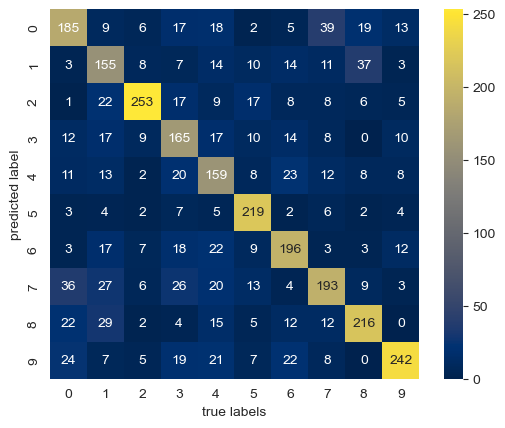

Accuracy: 0.661000000
Precision: 0.661000000
Recall: 0.661000000
F1: 0.661000000


In [29]:
mat = confusion_matrix(y_test, y_cb)
sea.heatmap(mat.T, square = True, annot=True, fmt = "d", cmap='cividis')
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
quality_metrics(y_test, y_cb)

# Bert

In [9]:
dataset = dataset.drop(columns=['url', 'Unnamed: 0', 'tags_names', 'title'])

In [11]:
clses = ['Computer Vision', 'Control Systems', 'Cyber Security', 'Database', 'Expert', 'Fuzzy', "Information Retrieval, Recommender Systems", 'Neural Nets', 'Robotic', 'Text Mining']
dic_lbls = {clses[i]:i  for i in range(10)}
dataset = dataset.replace(dic_lbls)
dataset['labels'] = dataset['class']
dataset = dataset.drop(columns=['class'])

In [199]:
training['text'] = training['text'].agg(' '.join)

In [200]:
test['text'] = test['text'].agg(' '.join)

In [201]:
df = pd.concat([training, test])

In [68]:
train, valid, test = \
              np.split(dataset.sample(frac=1, random_state=42),
                       [int(.6*len(dataset)), int(.8*len(dataset))])

In [72]:
from transformers import DistilBertTokenizerFast
PRETRAINED_LM = "bert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

C:\Users\777\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\777\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenizatio

DistilBertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [73]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [74]:
train_input_ids, train_att_masks = encode(train['abstract'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid['abstract'].values.tolist())
test_input_ids, test_att_masks = encode(test['abstract'].values.tolist())

In [75]:
import torch
train_y = torch.LongTensor(train['labels'].values.tolist())
valid_y = torch.LongTensor(valid['labels'].values.tolist())
test_y = torch.LongTensor(test['labels'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([6000]), torch.Size([2000]), torch.Size([2000]))

In [76]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [77]:
from transformers import DistilBertForSequenceClassification

In [78]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                            num_labels=test['labels'].nunique(),
                                                            output_attentions=False,
                                                            output_hidden_states=False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.

In [138]:
"""from transformers import GPT2ForSequenceClassification
N_labels = len(train.labels.unique())
model = GPT2ForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)"""

'from transformers import GPT2ForSequenceClassification\nN_labels = len(train.labels.unique())\nmodel = GPT2ForSequenceClassification.from_pretrained(PRETRAINED_LM,\n                                                      num_labels=N_labels,\n                                                      output_attentions=False,\n                                                      output_hidden_states=False)'

In [1]:
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
model = model.cuda()

NameError: name 'model' is not defined

In [82]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS =3
LEARNING_RATE = 5e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

In [83]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Validation:   0%|          | 0/125 [00:00<?, ?it/s]

375/375 train loss: 1.1608743586937587 
125/125 val loss: 0.8366694792509078 
Epoch:  2


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Validation:   0%|          | 0/125 [00:00<?, ?it/s]

375/375 train loss: 0.7048617930610974 
125/125 val loss: 0.772274053812027 
Epoch:  3


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Validation:   0%|          | 0/125 [00:00<?, ?it/s]

375/375 train loss: 0.5082805742025376 
125/125 val loss: 0.7866413235068321 


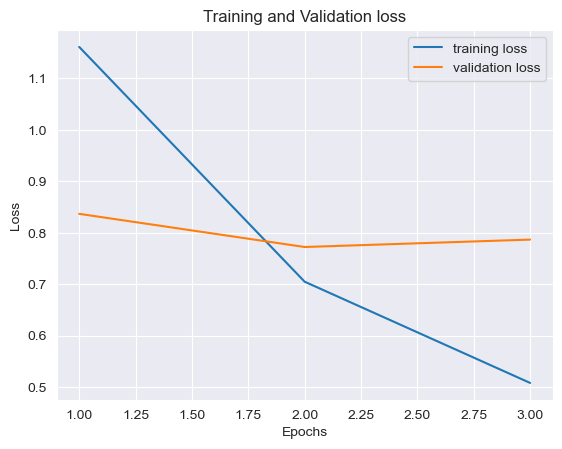

In [84]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [85]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, valid['labels'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       199
           1       0.68      0.67      0.67       201
           2       0.91      0.82      0.86       255
           3       0.67      0.72      0.69       191
           4       0.68      0.73      0.70       160
           5       0.73      0.90      0.81       173
           6       0.76      0.71      0.73       199
           7       0.75      0.74      0.75       205
           8       0.82      0.83      0.83       187
           9       0.88      0.80      0.83       230

    accuracy                           0.78      2000
   macro avg       0.77      0.78      0.77      2000
weighted avg       0.78      0.78      0.78      2000



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

In [218]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [219]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [220]:
print('classifiation report')
print(classification_report(test_pred, test['labels'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       216
           1       0.72      0.80      0.76       176
           2       0.92      0.92      0.92       191
           3       0.88      0.83      0.85       215
           4       0.84      0.82      0.83       185
           5       0.94      0.96      0.95       183
           6       0.85      0.89      0.87       198
           7       0.85      0.84      0.85       223
           8       0.90      0.90      0.90       207
           9       0.89      0.86      0.87       206

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



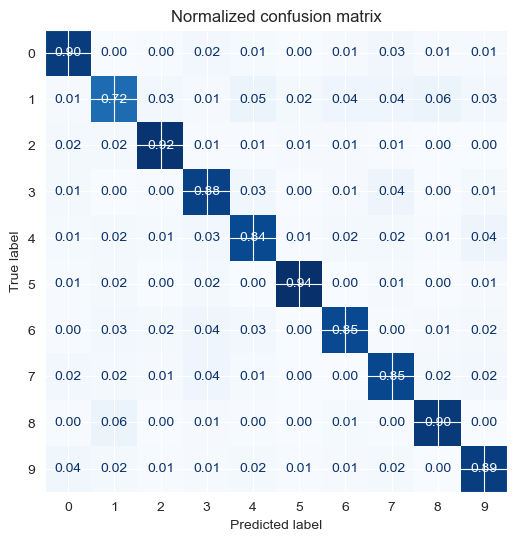

In [221]:
plot_confusion_matrix(test_pred, test['labels'].to_numpy())

In [226]:
from transformers import BertForSequenceClassification
N_labels = len(train.labels.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [227]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [228]:
model = model.cuda()

In [229]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 3
LEARNING_RATE = 5e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

In [230]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Validation:   0%|          | 0/125 [00:00<?, ?it/s]

375/375 train loss: 1.0123054607311885 
125/125 val loss: 0.5388729144930839 
Epoch:  2


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Validation:   0%|          | 0/125 [00:00<?, ?it/s]

375/375 train loss: 0.4796160947183768 
125/125 val loss: 0.4403958033025265 
Epoch:  3


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Validation:   0%|          | 0/125 [00:00<?, ?it/s]

375/375 train loss: 0.32735463773707546 
125/125 val loss: 0.4334605198353529 


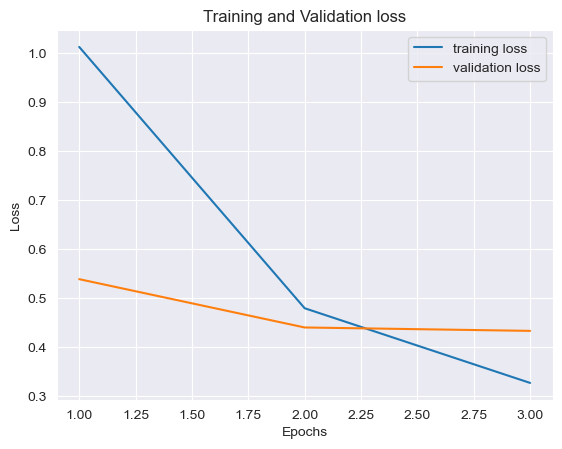

In [231]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [232]:
label_names = train.labels.unique()

In [233]:
label_names =  list(label_names)

In [234]:
type(label_names)

list

In [235]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, valid['labels'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       190
           1       0.79      0.81      0.80       182
           2       0.95      0.90      0.92       224
           3       0.87      0.81      0.84       194
           4       0.85      0.90      0.87       201
           5       0.90      0.98      0.94       200
           6       0.82      0.87      0.84       194
           7       0.90      0.86      0.88       237
           8       0.91      0.86      0.88       192
           9       0.89      0.88      0.88       186

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [236]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

In [237]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [238]:
print('classifiation report')
print(classification_report(test_pred, test['labels'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       216
           1       0.73      0.79      0.76       182
           2       0.92      0.91      0.91       193
           3       0.88      0.80      0.84       223
           4       0.83      0.84      0.84       177
           5       0.95      0.96      0.95       185
           6       0.86      0.88      0.87       202
           7       0.85      0.83      0.84       227
           8       0.88      0.91      0.89       201
           9       0.86      0.89      0.88       194

    accuracy                           0.86      2000
   macro avg       0.86      0.87      0.86      2000
weighted avg       0.87      0.86      0.86      2000



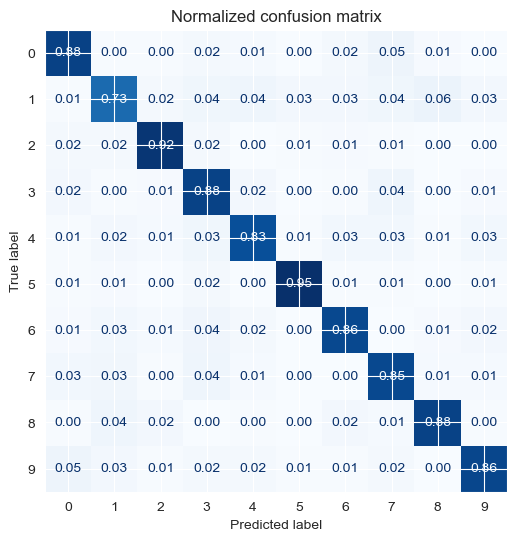

In [239]:
plot_confusion_matrix(test_pred,test['labels'].to_numpy())

In [86]:
test['pred'] = test_pred
test.reset_index(level=0)
print(test[test['labels']!=test['pred']].shape)
test[test['labels']!=test['pred']][['text','labels','pred']].head(500)

(304, 3)


,text,labels,pred
7872,neural motion field encoding grasp trajectory ...,1,8
7178,sparse vicious attack graph neural network mac...,1,7
5820,conformal prediction set limited false positiv...,0,6
4047,fully privacy preserving federated representat...,6,2
2769,bipedal locomotion nonlinear model predictive ...,8,1
...,...,...,...
1978,line visual sentence context aware line descri...,7,8
3104,bb kw mandarin keyword spotting system video k...,5,9
4926,deepxpalm tilt position rendering using palm w...,6,8
5375,adaptive differential filter fast communicatio...,0,7


In [240]:
df = pd.DataFrame({"Embedding and algorithm":["w2v+LR", "Fasttext+pretrained_f1", "DistilBertForSequenceClassification"], "Accuracy":["70%", "----","----"], "Precison":["70%", "83%","87%"], "Recall":["70%", "83%","87%"], "f1":["70%", "83%", "87%"], "Время обучения, с": ["10.8", "190.9", "34.7"]})
print(df.to_markdown(index=False))

| Embedding and algorithm             | Accuracy   | Precison   | Recall   | f1   |   Время обучения, с |
|:------------------------------------|:-----------|:-----------|:---------|:-----|--------------------:|
| w2v+LR                              | 70%        | 70%        | 70%      | 70%  |                10.8 |
| Fasttext+pretrained_f1              | ----       | 83%        | 83%      | 83%  |               190.9 |
| DistilBertForSequenceClassification | ----       | 87%        | 87%      | 87%  |                34.7 |


In [1]:
from transformers import BertTokenizer

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')